In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import time
import os
import pickle

from tbpp_model import TBPP512, TBPP512_dense
from tbpp_utils import PriorUtil
from ssd_data import InputGenerator
from tbpp_training import TBPPFocalLoss
from utils.model import load_weights
from utils.training import Logger

from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Data

In [2]:
from data_cracker import GTUtility
with open('gt_util_ksignboard.pkl', 'rb') as f:
    gt_util = pickle.load(f)

gt_util_train, gt_util_val = gt_util.randomSplit(split=0.8)

In [2]:
from data_cocotext import GTUtility

with open('gt_util_cocotext_train.pkl','rb') as f:
    gt_util_train = pickle.load(f)

with open('gt_util_cocotext_val.pkl','rb') as f:
    gt_util_val = pickle.load(f)


In [3]:
len(gt_util_train.image_names), len(gt_util_val.image_names)

(14708, 3424)

### Model

In [4]:
# TextBoxes++
model = TBPP512(softmax=False)
weights_path = None
freeze = []

experiment = 'tbpp512_cocotext_ex2'
#experiment = 'tbpp512_ksignboard_ex2'

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
batch_size = 16

In [6]:
prior_util = PriorUtil(model)

if weights_path is not None:
    load_weights(model, weights_path)

### Training

In [7]:
epochs = 50

gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size, augmentation=True)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size, model.image_size, augmentation=False)

for layer in model.layers:
    layer.trainable = not layer.name in freeze

In [8]:
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

#with open(checkdir+'/source.py','wb') as f:
#    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
#    f.write(source.encode())

tensorboard = TensorBoard(log_dir='./logs/tbpp', histogram_freq=0, batch_size=32, 
                                          write_graph=True, write_grads=False, write_images=False, 
                                          embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, 
                                          embeddings_data=None, update_freq='epoch')

In [ ]:
optim = keras.optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
#optim = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0)

# weight decay
regularizer = keras.regularizers.l2(5e-4) # None if disabled
#regularizer = None
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

loss = TBPPFocalLoss()

model.compile(optimizer=optim, loss=loss.compute, metrics=loss.metrics)

history = model.fit_generator(
        gen_train.generate(),
        steps_per_epoch=int(gen_train.num_batches/4), 
        epochs=epochs, 
        verbose=1, 
        callbacks=[
            keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
            Logger(checkdir),
            #LearningRateDecay()
            tensorboard
        ], 
        validation_data=gen_val.generate(), 
        validation_steps=gen_val.num_batches, 
        class_weight=None,
        max_queue_size=1, 
        workers=4, 
        use_multiprocessing=True, 
        initial_epoch=0, 
        #pickle_safe=False, # will use threading instead of multiprocessing, which is lighter on memory use but slower
        )

Instructions for updating:
Use tf.cast instead.


/home/ina/anaconda3/envs/ina/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50
229/229 [==============================] - 352s 2s/step - loss: 39.3463 - conf_loss: 0.0137 - loc_loss: 25.6627 - precision: 5.0995e-04 - recall: 0.0153 - accuracy: 0.1460 - fmeasure: 7.9495e-04 - num_pos: 431.3537 - num_neg: 1222832.6463 - val_loss: 29.8520 - val_conf_loss: 0.0048 - val_loc_loss: 25.0807 - val_precision: 3.7168e-04 - val_recall: 3.9518e-04 - val_accuracy: 0.4020 - val_fmeasure: 3.8128e-04 - val_num_pos: 475.7991 - val_num_neg: 1222788.2009

Epoch 00001: saving model to ./checkpoints/201904251759_tbpp512_cocotext_ex2/weights.001.h5
Epoch 2/50
217/229 [===========================>..] - ETA: 12s - loss: 28.6755 - conf_loss: 0.0039 - loc_loss: 24.7786 - precision: 6.2547e-04 - recall: 6.3666e-04 - accuracy: 0.4666 - fmeasure: 6.1426e-04 - num_pos: 456.4147 - num_neg: 1222807.5853

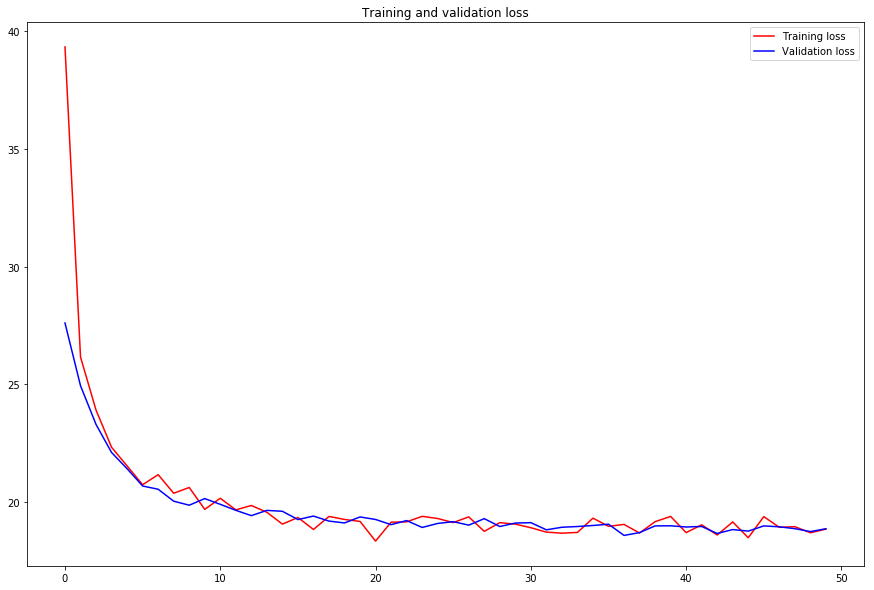

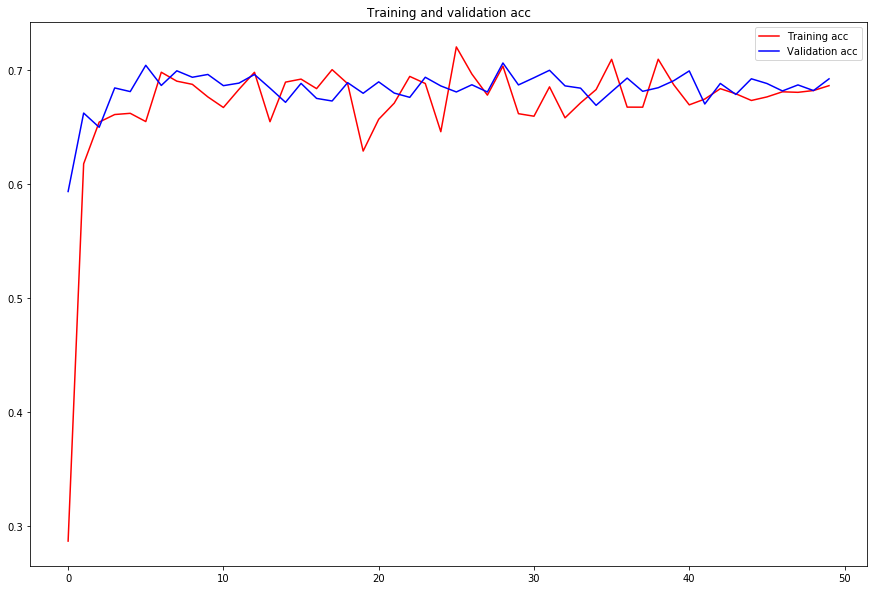

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b',label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b',label='Validation acc')

plt.title('Training and validation acc')
plt.legend()
plt.show()

from utils.model import calc_memory_usage, count_parameters
count_parameters(model)
calc_memory_usage(model)

## testing

In [9]:
# frequency of class instance in local ground truth, used for weightning the focal loss
s = np.zeros(gt_util.num_classes)
for i in range(1000):#range(gt_util.num_samples):
    egt = prior_util.encode(gt_util.data[i])
    s += np.sum(egt[:,-gt_util.num_classes:], axis=0)
sn = np.asarray(np.sum(s))/s
print(np.array(sn, dtype=np.int32))
print(sn/np.sum(sn))

[   1 1955]
[5.11274753e-04 9.99488725e-01]


In [12]:
#load_weights(model, './checkpoints/201904251146_tbpp512_ksignboard_ex2/weights.049.h5')
#checkdir = os.path.dirname(weights_path)

plot_name = 'tbpp512_ksignboard'
confidence_threshold = 0.35

In [13]:
_, inputs, images, data = gt_util_val.sample_random_batch(12)

preds = model.predict(inputs, batch_size=12, verbose=1)

12/12 [==============================] - 1s 45ms/step


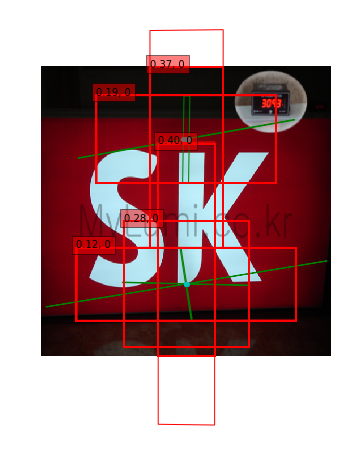

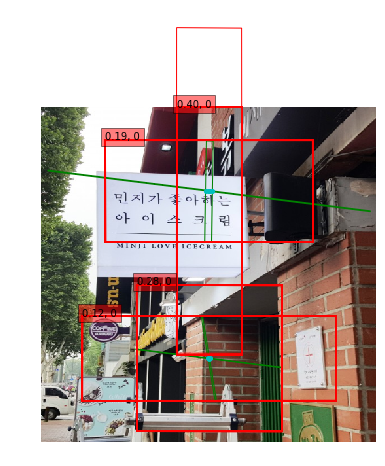

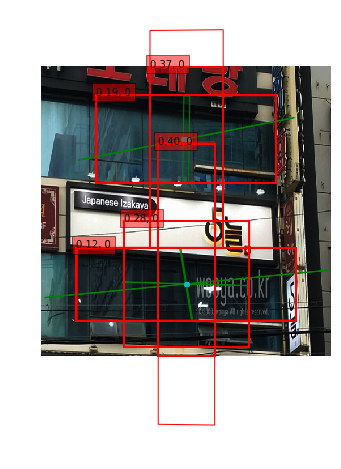

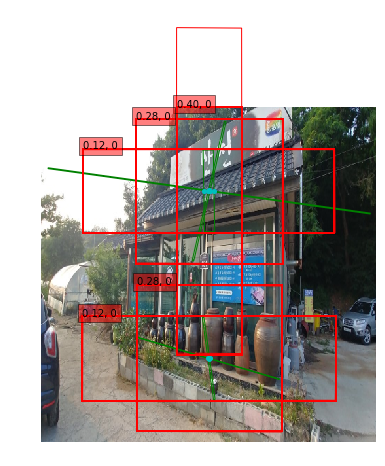

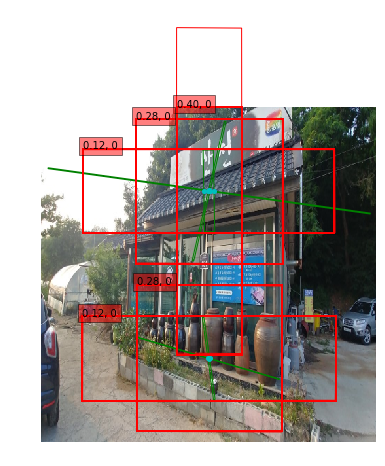

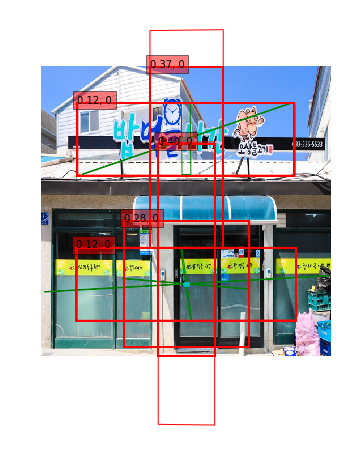

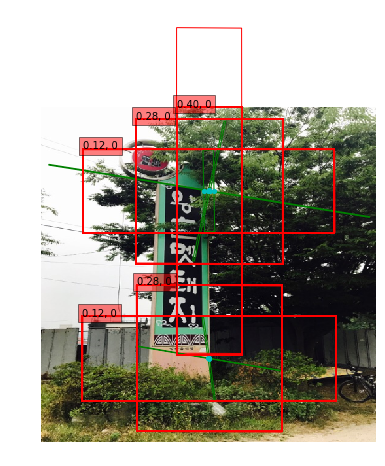

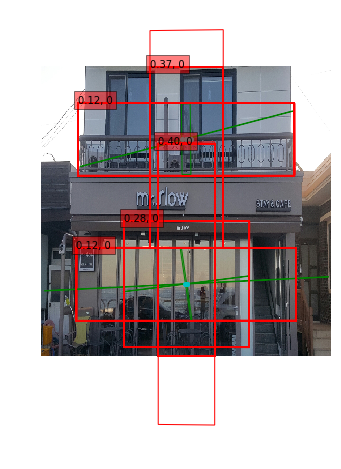

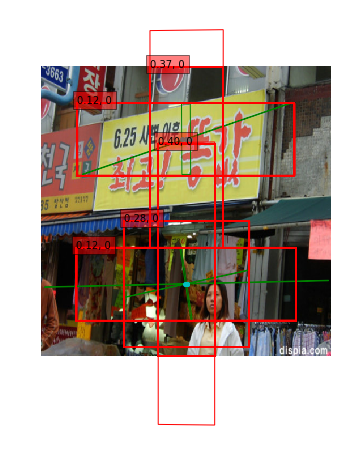

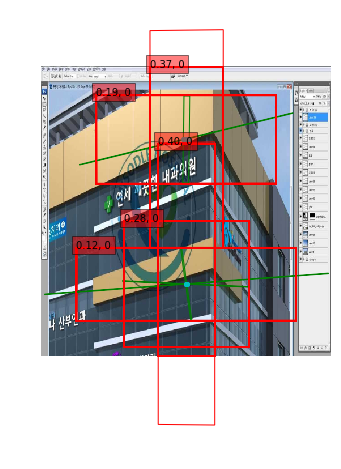

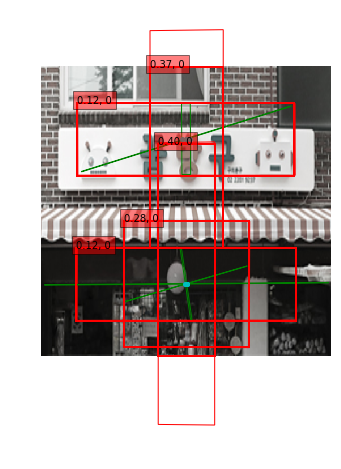

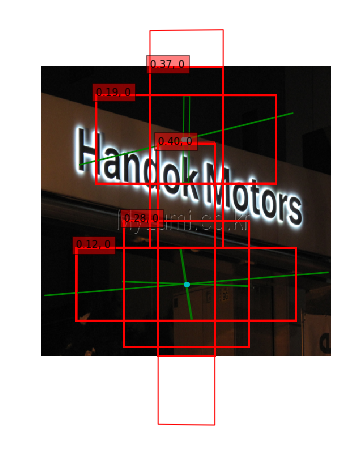

In [22]:
from utils.vis import plot_box
from utils.bboxes import rbox3_to_polygon, polygon_to_rbox3

for i in range(12):
    res = prior_util.decode(preds[i], confidence_threshold, fast_nms=False)
    bbox = res[:,0:4]
    quad = res[:,4:12]
    rbox = res[:,12:17]
    #print(bbox)
    
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    ax = plt.gca()
    for j in range(len(bbox)):
        #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
        plot_box(bbox[j]*512, box_format='xyxy', color='b')
        plot_box(np.reshape(quad[j],(-1,2))*512, box_format='polygon', color='r')
        plot_box(rbox3_to_polygon(rbox[j])*512, box_format='polygon', color='g')
        plt.plot(rbox[j,[0,2]]*512, rbox[j,[1,3]]*512, 'oc', markersize=4)
    prior_util.plot_results(res)
    plt.axis('off')
    plt.show()